In [1]:
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
tf.random.set_seed(1337)

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM

TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.2

TOKENIZER_MAX_WORDS = 20000

REVIEW_LENGTH = 256

data = pd.concat([chunk for chunk in tqdm(pd.read_csv("./clean_dataset.csv", chunksize=1000), desc="loading the dataset")])

train_data, test_data = train_test_split(data, test_size=TEST_SPLIT, random_state=1337, stratify=data["label"])

print(f"train data shape: {train_data.shape}")
print(f"test data shape:  {test_data.shape}")

print(f"tokenizing the test dataset")
tokenizer = Tokenizer(num_words=TOKENIZER_MAX_WORDS)
tokenizer.fit_on_texts(train_data["text"])

X_train = pad_sequences(tokenizer.texts_to_sequences(train_data["text"]), maxlen=REVIEW_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data["text"]), maxlen=REVIEW_LENGTH)

Y_train = train_data["label"]
Y_test = test_data["label"]

print("building the LSTM")
# ------------------ NEW CODE --------------------
from tensorflow.keras.callbacks import ModelCheckpoint

# CHANGES
# EMBED_DIM = 32 -> 64
# LSTM_OUT = 64 -> 128
# added dropout and recurrent_dropout
EMBED_DIM = 64
LSTM_OUT = 128

total_words = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(total_words, EMBED_DIM))
model.add(LSTM(LSTM_OUT, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print(model.summary())

checkpoint = ModelCheckpoint(
  'models/lstm.keras',
  monitor='accuracy',
  save_best_only=True,
  verbose=1
)

model.fit(X_train, Y_train, batch_size = 128, epochs = 5, callbacks=[checkpoint])

metrics = model.evaluate(X_test, Y_test)

loading the dataset: 50it [00:00, 104.04it/s]


train data shape: (40000, 2)
test data shape:  (10000, 2)
tokenizing the test dataset
building the LSTM


/Users/geko/unibo/nlp/project/venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.7471 - loss: 0.4927
Epoch 1: accuracy improved from -inf to 0.82480, saving model to models/lstm.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 132s 420ms/step - accuracy: 0.7473 - loss: 0.4924
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.8989 - loss: 0.2588
Epoch 2: accuracy improved from 0.82480 to 0.90443, saving model to models/lstm.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 155s 494ms/step - accuracy: 0.8989 - loss: 0.2588
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.9207 - loss: 0.2104
Epoch 3: accuracy improved from 0.90443 to 0.92642, saving model to models/lstm.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 149s 477ms/step - accuracy: 0.9207 - loss: 0.2103
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9399 - loss: 0.1642
Epoch 4: accuracy improved from 0.92642 to 0.94295, saving model to models/lstm.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 136s 433ms/step - accuracy: 0.9399 - los

313/313 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step
Accuracy:  0.8760
Precision: 0.8779
Recall:    0.8760
F1 Score:  0.8758


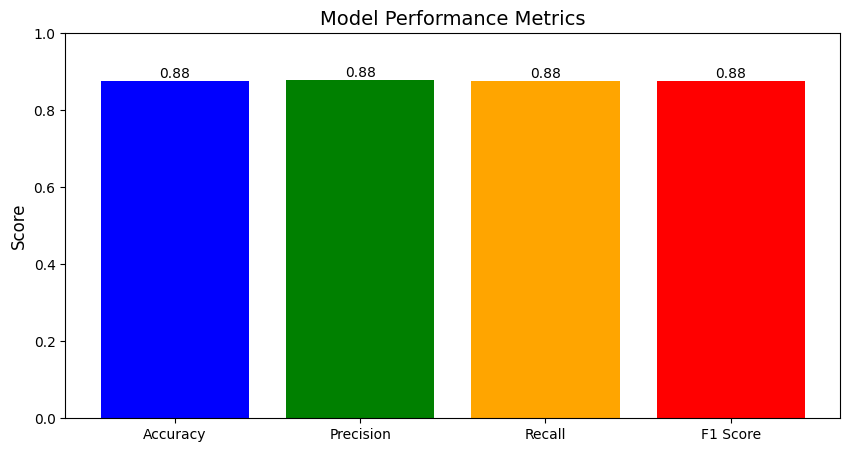

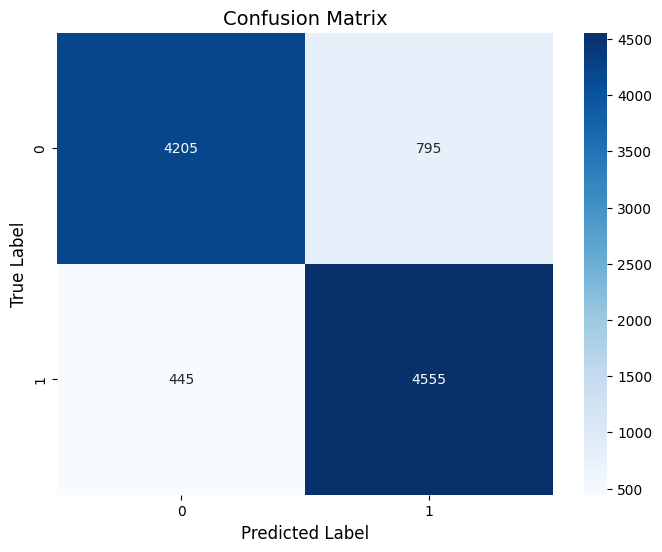

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, 
                             recall_score, f1_score, confusion_matrix)

# Generate predictions
y_pred = model.predict(X_test)

# Convert predictions to class labels
if y_pred.shape[-1] > 1:  # Multi-class classification
  y_pred_labels = np.argmax(y_pred, axis=1)
  y_true_labels = np.argmax(Y_test, axis=1)
else:  # Binary classification
  y_pred_labels = (y_pred > 0.5).astype(int).squeeze()
  y_true_labels = Y_test.squeeze()

# Calculate metrics
accuracy = accuracy_score(y_true_labels, y_pred_labels)
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

# Print metrics
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Plot metrics
plt.figure(figsize=(10, 5))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

bars = plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
plt.title('Model Performance Metrics', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1)

# Add values on top of bars
for bar in bars:
  height = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2., height,
    f'{height:.2f}',
    ha='center', va='bottom')

plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
  xticklabels=np.unique(y_true_labels), 
  yticklabels=np.unique(y_true_labels))
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# Usage example:
# plot_metrics_and_confusion_matrix(model, X_test, Y_test)